# Flight Delay Analysis and Prediction


## By Dong Zhang


## Introduction

Most people have flight delay experiences. Sometimes flight delays (including cancellations) can be a really big issue, especially for business trips or emergency flights. Flight delays are caused by various reasons, also depend on flight companies and airports. In this project, I try to classify and predict flight delays using machine learning techniques. I use the data of flight delays downloaded from the Bureau of Transportation Statistics. More data are required for better prediction.  

### Data 

The dataset is from the Bureau of Transportation Statistics:
https://www.transtats.bts.gov/OT_Delay/OT_DelayCause1.asp?pn=1

Data is collected between June, 2003 to Feb, 2019, from all airports and airlines in the US. Flight delays can be caused by different reasons, including Air Carrier Delay, Weather Delay, National Aviation System (NAS) Delay, Security Delay, Aircraft Arriving Delay, Cancellation and Diverted. The definitions of the variety of delays can be see here:
https://www.bts.dot.gov/explore-topics-and-geography/topics/airline-time-performance-and-causes-flight-delays

Each row of the data shows the number of total flights, the number of each type of delays, and the duration (in minutes) of each delay for an individual flight airline in an individual airports in one month. So this is not the raw data, but we can still learning much information from the data. Eventually, my goal is to predict the probability and waiting time of each delay cause. For this project, I take American Airline and Atlanta Airport (ATL) for case studies, compare them with the overall flight performance in the US. Then given the parameter set of year and month, I predict flight delays for AA/ATL. 

Other data includes the longitudes and latitudes of airports in the US (airport.csv). In future I will collect more data including not only the information by years and months, but also dates and hours. More data can be collected here:
https://transtats.bts.gov/ONTIME/Departures.aspx

In current stages, the data already shows many interesting results. 


## Part 1: Data Loading and Cleaning


In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) 

data = pd.read_csv('airline_delay.csv')
print(data.shape)
data.head(5)

(256285, 21)


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2003,6,AA,American Airlines Inc.,ABQ,"Albuquerque, NM: Albuquerque International Sun...",307.0,56.0,14.68,10.79,19.09,1.48,9.96,1.0,1.0,2530.0,510.0,621.0,676.0,25.0,698.0
1,2003,6,AA,American Airlines Inc.,ANC,"Anchorage, AK: Ted Stevens Anchorage Internati...",90.0,27.0,7.09,2.00,10.75,0.00,7.16,0.0,0.0,1390.0,271.0,83.0,581.0,0.0,455.0
2,2003,6,AA,American Airlines Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",752.0,186.0,33.99,27.82,104.76,1.90,17.53,5.0,0.0,8314.0,1367.0,1722.0,3817.0,139.0,1269.0
3,2003,6,AA,American Airlines Inc.,AUS,"Austin, TX: Austin - Bergstrom International",842.0,174.0,60.24,20.54,47.78,4.69,40.75,9.0,1.0,8344.0,3040.0,1032.0,1835.0,115.0,2322.0
4,2003,6,AA,American Airlines Inc.,BDL,"Hartford, CT: Bradley International",383.0,55.0,14.90,8.91,14.57,0.00,16.61,0.0,0.0,3137.0,815.0,574.0,555.0,0.0,1193.0


In [3]:
data.isnull().sum()

year                     0
month                    0
carrier                  0
carrier_name             0
airport                  0
airport_name             0
arr_flights            362
arr_del15              416
carrier_ct             362
weather_ct             362
nas_ct                 362
security_ct            362
late_aircraft_ct       362
arr_cancelled          362
arr_diverted           362
arr_delay              362
carrier_delay          362
weather_delay          362
nas_delay              362
security_delay         362
late_aircraft_delay    362
dtype: int64

In [4]:
data.dropna(inplace = True)

In [5]:
print(data.shape)
data.isnull().sum()

(255869, 21)


year                   0
month                  0
carrier                0
carrier_name           0
airport                0
airport_name           0
arr_flights            0
arr_del15              0
carrier_ct             0
weather_ct             0
nas_ct                 0
security_ct            0
late_aircraft_ct       0
arr_cancelled          0
arr_diverted           0
arr_delay              0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
dtype: int64

In [6]:
# No duplication

data[data.duplicated(keep=False)]

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay



## Part 2: Visualization


##  Part 3. Machine Learning Model

### 3.1 Multiple Classification

In [7]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

data_ML = data.drop(['carrier_name','airport_name'], axis=1)
print(data_ML.shape)
data_ML = data_ML[['year','month','carrier','arr_flights','arr_del15']]
data_ML.groupby(['year','month','carrier','arr_flights']).sum()
print(data_ML.shape)
data_ML['delay_rate'] = data_ML.arr_del15/data_ML.arr_flights
data_ML['year'] = (data_ML.year-2003.)/2019
data_ML['month'] = data_ML.month/12


col         = 'delay_rate'
conditions  = [ data_ML[col] <=0.15, (data_ML[col] >0.15) & (data_ML[col]<= 0.20), 
               (data_ML[col] >0.20) & (data_ML[col]<= 0.25), data_ML[col]> 0.25]
choices     = [0, 1, 2, 3]

data_ML['class'] = np.select(conditions, choices, default=np.nan)
data_ML['class'] = data_ML['class'].astype(int)

data_ML.head(10)

(255869, 19)
(255869, 5)


,year,month,carrier,arr_flights,arr_del15,delay_rate,class
0,0.0,0.5,AA,307.0,56.0,0.182410,1
1,0.0,0.5,AA,90.0,27.0,0.300000,3
2,0.0,0.5,AA,752.0,186.0,0.247340,2
3,0.0,0.5,AA,842.0,174.0,0.206651,2
4,0.0,0.5,AA,383.0,55.0,0.143603,0
5,0.0,0.5,AA,89.0,12.0,0.134831,0
6,0.0,0.5,AA,445.0,82.0,0.184270,1
7,0.0,0.5,AA,1266.0,225.0,0.177725,1
8,0.0,0.5,AA,119.0,27.0,0.226891,2
9,0.0,0.5,AA,593.0,101.0,0.170320,1


In [8]:
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()
data_ML['carrier'] = encoder.fit_transform(data_ML['carrier'])

In [21]:
y = data_ML['class']
X = data_ML.drop(['arr_flights','arr_del15','delay_rate','class'], axis=1)

X.head()

,year,month,carrier
0,0.0,0.5,1
1,0.0,0.5,1
2,0.0,0.5,1
3,0.0,0.5,1
4,0.0,0.5,1


In [22]:
y.value_counts()

0    81182
3    74695
1    54360
2    45632
Name: class, dtype: int64

In [23]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(204695, 3)
(51174, 3)
(204695,)
(51174,)


In [25]:
from sklearn.metrics import confusion_matrix,classification_report

logreg =LogisticRegression(penalty='l2', solver='lbfgs')

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
#fpr_log, tpr_log, _ = roc_curve(y_test, y_pred)

#print(f1_score(y_test, y_pred))
#print(precision_score(y_test, y_pred))
#print(recall_score(y_test, y_pred))

print("confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

confusion matrix: 
 [[11477     0     0  4786]
 [ 7033     0     0  3634]
 [ 5940     0     0  3211]
 [ 9937     0     0  5156]]
              precision    recall  f1-score   support

           0       0.33      0.71      0.45     16263
           1       0.00      0.00      0.00     10667
           2       0.00      0.00      0.00      9151
           3       0.31      0.34      0.32     15093

    accuracy                           0.33     51174
   macro avg       0.16      0.26      0.19     51174
weighted avg       0.20      0.33      0.24     51174



In [26]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(min_samples_split=3,random_state=20)

DT.fit(X_train,y_train)
y_pred =DT.predict(X_test)

print("confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

confusion matrix: 
 [[11936  1791   509  2027]
 [ 4791  2452   890  2534]
 [ 2388  1789  1083  3891]
 [ 2040  1311   990 10752]]
              precision    recall  f1-score   support

           0       0.56      0.73      0.64     16263
           1       0.33      0.23      0.27     10667
           2       0.31      0.12      0.17      9151
           3       0.56      0.71      0.63     15093

    accuracy                           0.51     51174
   macro avg       0.44      0.45      0.43     51174
weighted avg       0.47      0.51      0.48     51174



In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=200, max_features = 3,random_state=20,oob_score=True)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)

print("confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

confusion matrix: 
 [[11860  1817   503  2083]
 [ 4711  2450   885  2621]
 [ 2335  1767  1068  3981]
 [ 1993  1282   950 10868]]
              precision    recall  f1-score   support

           0       0.57      0.73      0.64     16263
           1       0.33      0.23      0.27     10667
           2       0.31      0.12      0.17      9151
           3       0.56      0.72      0.63     15093

    accuracy                           0.51     51174
   macro avg       0.44      0.45      0.43     51174
weighted avg       0.47      0.51      0.48     51174



In [28]:
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier(max_depth=6, learning_rate=0.01, n_estimators=200)

xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

print("confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

confusion matrix: 
 [[11977   418    45  3823]
 [ 5756   652   139  4120]
 [ 3627   490   210  4824]
 [ 3602   337   175 10979]]
              precision    recall  f1-score   support

           0       0.48      0.74      0.58     16263
           1       0.34      0.06      0.10     10667
           2       0.37      0.02      0.04      9151
           3       0.46      0.73      0.57     15093

    accuracy                           0.47     51174
   macro avg       0.41      0.39      0.32     51174
weighted avg       0.43      0.47      0.38     51174



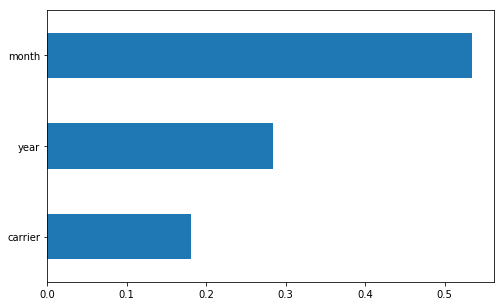

In [29]:
importances = xgb.feature_importances_
important_list = {}
for i in np.argsort(importances)[::-1]:
    important_list[X.columns[i]] = importances[i]
    
fig, ax = plt.subplots(figsize=(8, 5))
pd.Series(important_list)[::-1].plot(kind='barh',ax=ax)
plt.show()

### 3.2 Binary Classification

In [30]:
col         = 'delay_rate'
conditions  = [ data_ML[col] <=0.20, data_ML[col]> 0.20]
choices     = [0, 1]

data_ML['class'] = np.select(conditions, choices, default=np.nan)
data_ML['class'] = data_ML['class'].astype(int)

data_ML.head(10)

,year,month,carrier,arr_flights,arr_del15,delay_rate,class
0,0.0,0.5,1,307.0,56.0,0.182410,0
1,0.0,0.5,1,90.0,27.0,0.300000,1
2,0.0,0.5,1,752.0,186.0,0.247340,1
3,0.0,0.5,1,842.0,174.0,0.206651,1
4,0.0,0.5,1,383.0,55.0,0.143603,0
5,0.0,0.5,1,89.0,12.0,0.134831,0
6,0.0,0.5,1,445.0,82.0,0.184270,0
7,0.0,0.5,1,1266.0,225.0,0.177725,0
8,0.0,0.5,1,119.0,27.0,0.226891,1
9,0.0,0.5,1,593.0,101.0,0.170320,0


In [31]:
y = data_ML['class']
X = data_ML.drop(['arr_flights','arr_del15','delay_rate','class'], axis=1)

X.head()

,year,month,carrier
0,0.0,0.5,1
1,0.0,0.5,1
2,0.0,0.5,1
3,0.0,0.5,1
4,0.0,0.5,1


In [32]:
y.value_counts()

0    135542
1    120327
Name: class, dtype: int64

In [33]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
from sklearn.metrics import roc_curve, auc


logreg =LogisticRegression(penalty='l2', solver='lbfgs')

logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred)

print("confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

confusion matrix: 
 [[23910  3237]
 [20023  4004]]
              precision    recall  f1-score   support

           0       0.54      0.88      0.67     27147
           1       0.55      0.17      0.26     24027

    accuracy                           0.55     51174
   macro avg       0.55      0.52      0.46     51174
weighted avg       0.55      0.55      0.48     51174



In [36]:
DT = DecisionTreeClassifier(min_samples_split=3,random_state=20)
DT.fit(X_train,y_train)
y_pred =DT.predict(X_test)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)

print("confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

confusion matrix: 
 [[21032  6115]
 [ 7114 16913]]
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     27147
           1       0.73      0.70      0.72     24027

    accuracy                           0.74     51174
   macro avg       0.74      0.74      0.74     51174
weighted avg       0.74      0.74      0.74     51174



In [38]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=20,oob_score=True)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)

print("confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

confusion matrix: 
 [[20976  6171]
 [ 7064 16963]]
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     27147
           1       0.73      0.71      0.72     24027

    accuracy                           0.74     51174
   macro avg       0.74      0.74      0.74     51174
weighted avg       0.74      0.74      0.74     51174



In [39]:
xgb = XGBClassifier(learning_rate=0.01, n_estimators=200)

xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred)

print("confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

confusion matrix: 
 [[18935  8212]
 [10004 14023]]
              precision    recall  f1-score   support

           0       0.65      0.70      0.68     27147
           1       0.63      0.58      0.61     24027

    accuracy                           0.64     51174
   macro avg       0.64      0.64      0.64     51174
weighted avg       0.64      0.64      0.64     51174



In [41]:
# add airport

data_ML = data[['year','month','carrier','airport','arr_flights','arr_del15']]
data_ML.groupby(['year','month','carrier','airport','arr_flights']).sum()
print(data_ML.shape)
data_ML['delay_rate'] = data_ML.arr_del15/data_ML.arr_flights
data_ML['year'] = (data_ML.year-2003.)/2019
data_ML['month'] = data_ML.month/12
data_ML.head(10)

(255869, 6)


,year,month,carrier,airport,arr_flights,arr_del15,delay_rate
0,0.0,0.5,AA,ABQ,307.0,56.0,0.182410
1,0.0,0.5,AA,ANC,90.0,27.0,0.300000
2,0.0,0.5,AA,ATL,752.0,186.0,0.247340
3,0.0,0.5,AA,AUS,842.0,174.0,0.206651
4,0.0,0.5,AA,BDL,383.0,55.0,0.143603
5,0.0,0.5,AA,BHM,89.0,12.0,0.134831
6,0.0,0.5,AA,BNA,445.0,82.0,0.184270
7,0.0,0.5,AA,BOS,1266.0,225.0,0.177725
8,0.0,0.5,AA,BUR,119.0,27.0,0.226891
9,0.0,0.5,AA,BWI,593.0,101.0,0.170320


In [42]:
encoder = LabelEncoder()
data_ML['carrier'] = encoder.fit_transform(data_ML['carrier'])

encoder = LabelEncoder()
data_ML['airport'] = encoder.fit_transform(data_ML['airport'])

In [44]:
data_ML.carrier.unique()

array([ 1,  3,  4,  5,  6,  7,  8, 10, 13, 14, 16, 18, 19, 20, 21, 22, 24,
       12, 17,  9, 26,  2, 25,  0, 23, 15, 27, 11])

In [45]:
data_ML.airport.unique()

array([  2,  17,  22,  24,  29,  35,  43,  45,  56,  57,  74,  76,  77,
        82,  93,  95,  96,  97, 104, 105, 112, 115, 121, 125, 129, 164,
       166, 167, 169, 174, 176, 177, 184, 193, 195, 196, 200, 204, 206,
       215, 216, 217, 218, 229, 231, 233, 235, 236, 241, 257, 258, 265,
       267, 269, 270, 272, 273, 274, 282, 283, 288, 289, 295, 305, 307,
       314, 317, 319, 323, 324, 326, 327, 335, 336, 338, 344, 346, 348,
       351, 353, 360, 362, 363, 372, 375, 377, 394,   9,  10,  13,  30,
        44,  51,  63, 100, 106, 123, 140, 153, 199, 201, 271, 277, 303,
       332, 343, 392, 395,  54,  55, 321, 368,  48,  53,  68,  85, 146,
       151, 214, 240, 263, 298, 309, 328, 358,   0,   8,  14,  23,  25,
        26,  28,  33,  34,  42,  59,  60,  66,  67,  70,  86,  88, 119,
       124, 133, 135, 137, 150, 152, 202, 213, 220, 228, 232, 243, 247,
       255, 290, 320, 330, 333, 339, 371, 373, 378, 382,  36,  58,  91,
       127, 154, 163, 194, 246, 250, 256, 301, 370, 391,   1,   

In [47]:
data_ML.head()

,year,month,carrier,airport,arr_flights,arr_del15,delay_rate
0,0.0,0.5,1,2,307.0,56.0,0.182410
1,0.0,0.5,1,17,90.0,27.0,0.300000
2,0.0,0.5,1,22,752.0,186.0,0.247340
3,0.0,0.5,1,24,842.0,174.0,0.206651
4,0.0,0.5,1,29,383.0,55.0,0.143603


In [48]:
col         = 'delay_rate'
conditions  = [ data_ML[col] <=0.20, data_ML[col]> 0.20]
choices     = [0, 1]

data_ML['class'] = np.select(conditions, choices, default=np.nan)
data_ML['class'] = data_ML['class'].astype(int)

data_ML.head(10)

,year,month,carrier,airport,arr_flights,arr_del15,delay_rate,class
0,0.0,0.5,1,2,307.0,56.0,0.182410,0
1,0.0,0.5,1,17,90.0,27.0,0.300000,1
2,0.0,0.5,1,22,752.0,186.0,0.247340,1
3,0.0,0.5,1,24,842.0,174.0,0.206651,1
4,0.0,0.5,1,29,383.0,55.0,0.143603,0
5,0.0,0.5,1,35,89.0,12.0,0.134831,0
6,0.0,0.5,1,43,445.0,82.0,0.184270,0
7,0.0,0.5,1,45,1266.0,225.0,0.177725,0
8,0.0,0.5,1,56,119.0,27.0,0.226891,1
9,0.0,0.5,1,57,593.0,101.0,0.170320,0


In [49]:
y = data_ML['class']
X = data_ML.drop(['arr_flights','arr_del15','delay_rate','class'], axis=1)

X.head()

,year,month,carrier,airport
0,0.0,0.5,1,2
1,0.0,0.5,1,17
2,0.0,0.5,1,22
3,0.0,0.5,1,24
4,0.0,0.5,1,29


In [50]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [51]:
DT = DecisionTreeClassifier(min_samples_split=3,random_state=20)
DT.fit(X_train,y_train)
y_pred =DT.predict(X_test)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)

print("confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

confusion matrix: 
 [[19976  7177]
 [ 8745 15276]]
              precision    recall  f1-score   support

           0       0.70      0.74      0.72     27153
           1       0.68      0.64      0.66     24021

    accuracy                           0.69     51174
   macro avg       0.69      0.69      0.69     51174
weighted avg       0.69      0.69      0.69     51174



In [52]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=20,oob_score=True)
rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)

print("confusion matrix: \n", confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

confusion matrix: 
 [[18734  8419]
 [ 8363 15658]]
              precision    recall  f1-score   support

           0       0.69      0.69      0.69     27153
           1       0.65      0.65      0.65     24021

    accuracy                           0.67     51174
   macro avg       0.67      0.67      0.67     51174
weighted avg       0.67      0.67      0.67     51174



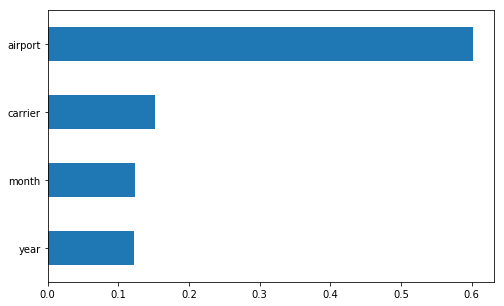

In [53]:
importances = rf_model.feature_importances_
important_list = {}
for i in np.argsort(importances)[::-1]:
    important_list[X.columns[i]] = importances[i]
    
fig, ax = plt.subplots(figsize=(8, 5))
pd.Series(important_list)[::-1].plot(kind='barh',ax=ax)
plt.show()